In [1]:
import geopandas as gpd
import pandas as pd
import rasterio 
import rioxarray as rxr
import xarray as xr

## Calculating the Normalized Difference Index

## 1.Load Layers

In [2]:
fp = "data/2023-02-22-sentinel-2-red-band.tiff"
red = rxr.open_rasterio(fp, masked=True).squeeze()

fp_NIV = "data/2023-02-22-sentinel-2-NIR-band.tiff"
NIR = rxr.open_rasterio(fp_NIV, masked=True)
red
NIR

<xarray.DataArray (band: 1, y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## Why use masked= True?

The reason to that is to ensure that the no data values do not p;ot and are assigned nan ot nodata.

## Checking the CRS of both rasters

In [3]:
print("The CRS for this data is:", red.rio.crs)
print("The CRS for this data is:", NIR.rio.crs)


The CRS for this data is: EPSG:4326
The CRS for this data is: EPSG:4326


## View the spatial extent

In [4]:
print("Is the spatial extent the same?",
      red.rio.bounds() == NIR.rio.bounds())

Is the spatial extent the same? True


## Spatial resolution

In [5]:
print("Is the resolution the same?",
      red.rio.resolution() == NIR.rio.resolution())

Is the resolution the same? True


## Why check Resolution, CRS, and extent?

After checking that they are all the same it means it is safe to subtract the two rasters from each other and calculate the NDVI


## 2. Calculate the NDVI. Export and save to a file as 'data/2023-02-22-sentinel-2-NDVI.tiff'

NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion:

(NIR - R) / (NIR + R)




In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
import rioxarray as rxr
from shapely.geometry import mapping


## 3. Plot the NDVI 

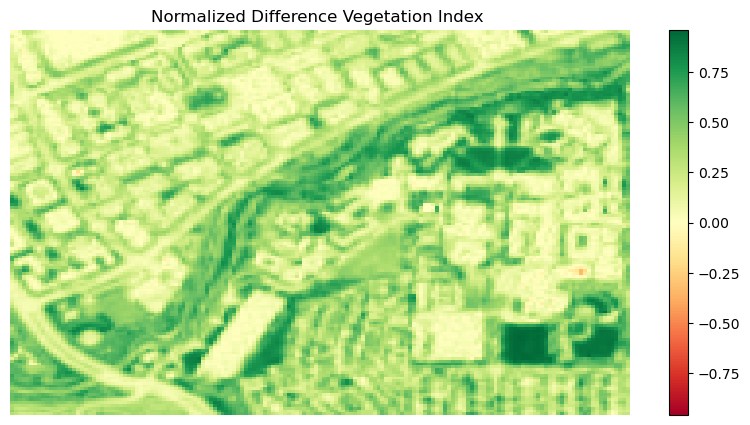

In [7]:
NDVI = ((NIR - red) / (NIR + red))


f, ax = plt.subplots(figsize=(10, 5))
NDVI.plot(cmap="RdYlGn")
ax.set(title="Normalized Difference Vegetation Index ")
ax.set_axis_off()
plt.show()

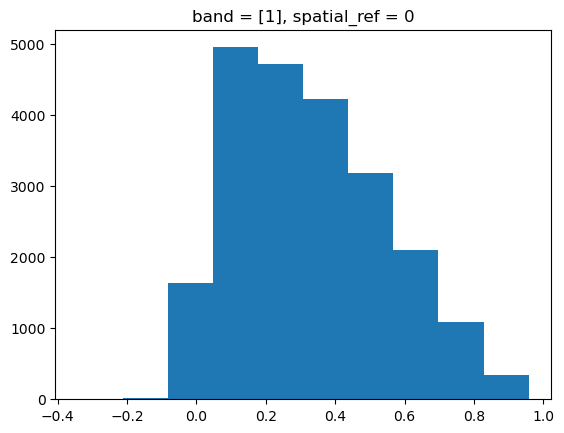

In [8]:
NDVI.plot.hist()
plt.show()

## Export and save

In [9]:
import os
data_path = os.path.join("data")


In [10]:
NDVI_data_path = os.path.join(data_path, "2023-02-22-sentinel-2-NDVI.tiff")
NDVI_data_path

'data/2023-02-22-sentinel-2-NDVI.tiff'

In [11]:
# Make sure that your output data has a crs & no data value defined
print("The crs is", NDVI.rio.crs)
print("The no data value is", NDVI.rio.nodata)

The crs is EPSG:4326
The no data value is None


In [12]:
# Export data to geotiff
NDVI.rio.to_raster(NDVI_data_path)

In [13]:
# Reopen the data
NDVI_rxred = rxr.open_rasterio(NDVI_data_path, masked=True).squeeze()
NDVI_rxred

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## What does a histogram represents?

A histogram quantifies the distribution of values found in your data.

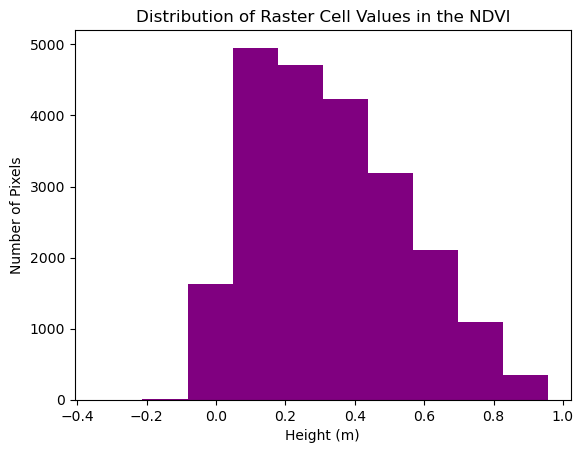

In [14]:
f, ax = plt.subplots()
NDVI_rxred.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the NDVI",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

## 4.Plotting a Histogram

custom bins:  bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]



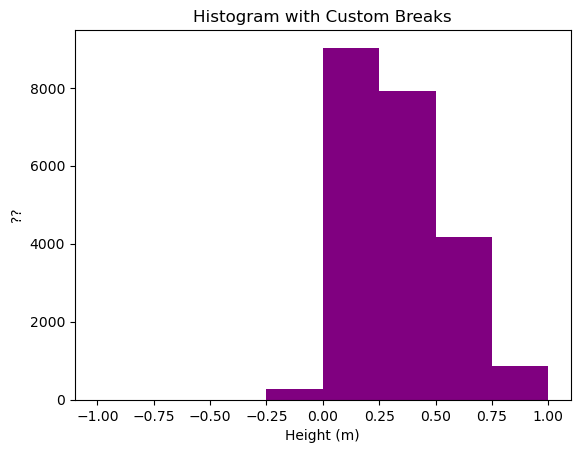

In [15]:
# Histogram with custom breaks
f, ax = plt.subplots()
NDVI_rxred.plot.hist(color="purple",
                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="??")

plt.show()

## Manually Reclassify NDVI Data


Reclassify according to the ranges below

- <0: water 
- 0 to 0.2: urban/barren
- 0.2 to 0.5: low vegetation
- $\gt$ 0.5: high vegetation

In [16]:
print(' min value:', np.nanmin(NDVI_rxred ))
print(' max value:', np.nanmax(NDVI_rxred ))

 min value: -0.3420191
 max value: 0.95758915


In [17]:
# Check nodata value for your array
NDVI_rxred.rio.nodata

In [18]:
data_min_value = np.nanmin(NDVI_rxred)
data_max_value = np.nanmax(NDVI_rxred)
print(data_min_value, data_max_value)

-0.3420191 0.95758915


In [19]:
class_bins = [-np.inf, 0, 0.2, 0.5, np.inf]
class_bins

[-inf, 0, 0.2, 0.5, inf]

In [20]:
NDVI_rxred_class = xr.apply_ufunc(np.digitize,
                                     NDVI_rxred,
                                     class_bins)

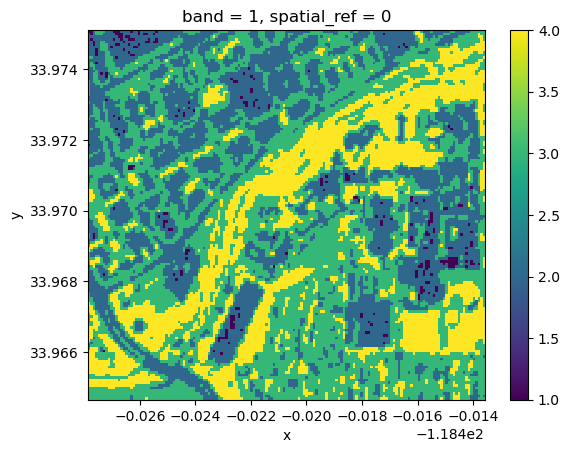

In [21]:
im = NDVI_rxred_class.plot.imshow()
ax.set_axis_off()

## 2.Plot the data using the following parameters:
colors = ['blue', 'beige', 'green', 'darkgreen']

class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]

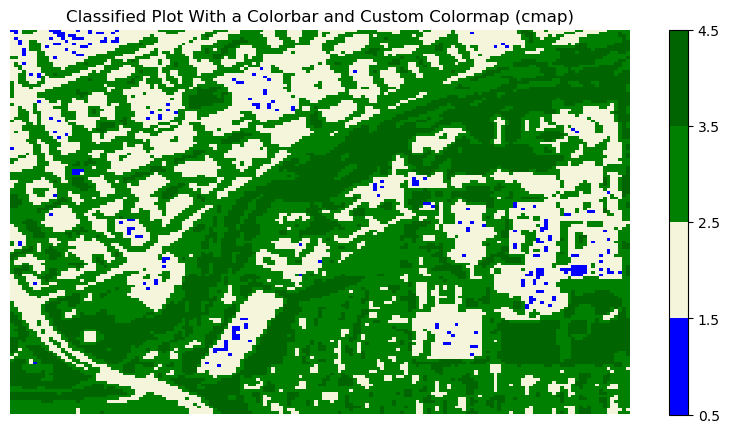

In [22]:
colors = ['blue', 'beige', 'green', 'darkgreen']
class_bins =  [0.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
NDVI_rxred_class.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()

## 3. Create a Histogram

Create a histogram of the classified NDVI data. Give rough approximations of the percentages of each cateogry (i.e. ~20% water, ~40% barren/urban land etc.)


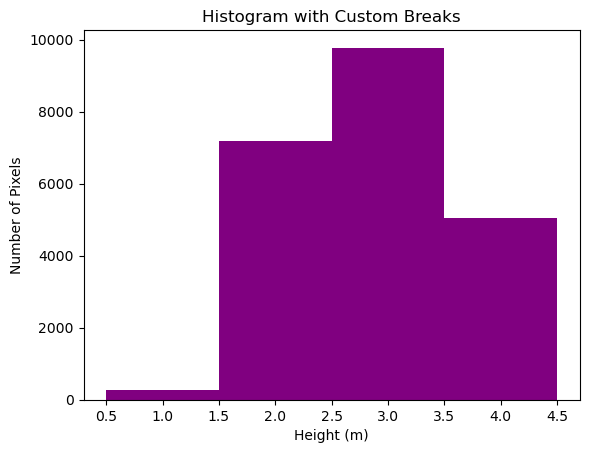

In [23]:
# Histogram of classified NDVI
f, ax = plt.subplots()
NDVI_rxred_class.plot.hist(color="purple",
                        bins=[0.5, 1.5, 2.5, 3.5, 4.5])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

In [24]:
import numpy as np
frequencies = np.histogram(NDVI_rxred_class,class_bins)

In [25]:
frequencies

(array([ 272, 7172, 9775, 5041]), array([0.5, 1.5, 2.5, 3.5, 4.5]))

In [26]:
import numpy as np
arr = np.array([ 272, 7172, 9775, 5041])

In [27]:
sum_vals = np.sum(arr1)
sum_vals

NameError: name 'arr1' is not defined

In [ ]:
water = (272/sum_vals)*100
urban = (7172/sum_vals)*100
low_vegetation = (9775/sum_vals)*100
high_vegetation = (5041/sum_vals)*100

In [ ]:
print(water, urban, low_vegetation, high_vegetation)

In [ ]:
print(water+ urban+low_vegetation+high_vegetation)